In [15]:
import triton
import triton.language as tl
import torch
import os
os.environ['TRITON_PRINT_AUTOTUNING']= '1'
from flash_muon_cuda import matmul_transpose_assign, matmul_transpose
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# @triton.autotune([triton.Config({"BLOCK_M":bm, "BLOCK_N":bn, "BLOCK_K":bk, "GROUP_SIZE_M":gm}, num_warps=nw, num_stages=4)
#                   for bm in [32, 64]
#                   for bn in [32, 64]
#                   for bk in [64]
#                   for nw in [1,2,4,8]
#                   for gm in [8]
#                   ], key=["N"])
@triton.jit
def matmul_kernel(X, 
                  Y, 
                  N: tl.constexpr,
                  BLOCK_M:tl.constexpr=64,
                  BLOCK_N:tl.constexpr=64,
                  BLOCK_K:tl.constexpr=64,
                  GROUP_SIZE_M:tl.constexpr=16,
                  ):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(N, BLOCK_M)
    num_pid_n = tl.cdiv(N, BLOCK_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    if (pid_m * BLOCK_M + BLOCK_M) <= (pid_n * BLOCK_N):
        return

    off_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    off_n = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    a_ptrs = X + off_m[:, None] * N + tl.arange(0, BLOCK_K)[None, :]
    # b_ptrs = X + off_n[None, :] * N + tl.arange(0, BLOCK_K)[:, None]
    b_ptrs = X + off_n[:, None] * N + tl.arange(0, BLOCK_K)[None, :]
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)

    for _ in range(0, tl.cdiv(N, BLOCK_K)):
        b = tl.load(b_ptrs)
        a = tl.load(a_ptrs)
        # acc = tl.dot(a, b, acc)
        acc = tl.dot(a, tl.permute(b, (1, 0)), acc)
        a_ptrs += BLOCK_K
        b_ptrs += BLOCK_K

    y_ptrs1 = Y + off_m[:, None] * N + off_n[None, :]
    tl.store(y_ptrs1, acc)

    y_ptrs2 = Y + off_m[None, :] + off_n[:, None] * N
    tl.store(y_ptrs2, tl.permute(acc, (1,0)))

    # y_ptrs2 = Y + off_m[:, None] + off_n[None, :] * N
    # tl.store(y_ptrs2, acc)

def matmul(x, out=None):
    if out is None:
        out = torch.zeros_like(x)
    M, N = x.shape
    assert N % 128 == 0 and M % 128 == 0
    kwargs = {"BLOCK_M":128 if N>=4096 else 64, "BLOCK_N":128 if N>=4096 else 64, "BLOCK_K":64, "num_warps":4, "num_stages":4, "GROUP_SIZE_M":8}
    grid = lambda meta: (triton.cdiv(M, meta['BLOCK_M']) * triton.cdiv(N, meta['BLOCK_N']), )
    matmul_kernel[grid](x, 
                        out, 
                        N,
                        **kwargs
                        )
    return out

a, b, c = (3.4445, -4.7750,  2.0315)
def run_triton(X, step=5):
    for _ in range(step):
        A = matmul(X)
        B = b * A + c * matmul(A)
        X = a * X + B @ X
    return X

def run_torch(X, step=5):
    for _ in range(step):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    return X


In [14]:
device = "cuda"
dtype = torch.bfloat16
N = 1024
x = torch.randn(N, N*2, device=device, dtype=dtype)

data = {"dim":[], "triton":[], "torch":[], "cuda":[]}
for i in range(1, 16):
    N = i * 1024
    x = torch.randn(N, N, device=device, dtype=dtype)
    ms1 = triton.testing.do_bench(lambda: matmul_transpose(x))
    ms2 = triton.testing.do_bench(lambda: matmul(x))
    ms3 = triton.testing.do_bench(lambda: torch.matmul(x, x.t()))
    data["dim"].append(N)
    data["triton"].append(ms2)
    data["torch"].append(ms3)
    data["cuda"].append(ms1)
df = pd.DataFrame(data)
print(df)
    

      dim    triton      torch       cuda
0    1024  0.015140   0.010127   0.038926
1    2048  0.035008   0.028196   0.075227
2    3072  0.093735   0.078786   0.209389
3    4096  0.131490   0.182103   0.274603
4    5120  0.257187   0.388764   0.668624
5    6144  0.401960   0.659991   0.987421
6    7168  0.652907   1.038566   1.600684
7    8192  0.945991   1.612713   2.040780
8    9216  1.363409   2.252778   2.856188
9   10240  1.805552   3.073045   4.144083
10  11264  2.400649   4.177691   5.132962
11  12288  3.163356   5.295420   6.708187
12  13312  3.983519   6.739612   8.395350
13  14336  4.998694   8.884090  10.290255
14  15360  6.046372  10.737362  12.774410


In [13]:
torch.allclose(matmul(x), torch.matmul(x, x.t()))

True

In [11]:
torch.matmul(x, x.t())

tensor([[ 1.5040e+04, -5.5750e+01,  2.5469e+00,  ...,  2.4100e+02,
          3.4600e+02,  6.3438e+00],
        [-5.5750e+01,  1.5040e+04, -2.1000e+02,  ...,  1.5062e+01,
          2.1400e+02, -1.9625e+01],
        [ 2.5469e+00, -2.1000e+02,  1.5680e+04,  ..., -2.9500e+01,
         -1.5000e+02, -1.1700e+02],
        ...,
        [ 2.4100e+02,  1.5062e+01, -2.9500e+01,  ...,  1.5232e+04,
         -2.1000e+02, -2.5625e+01],
        [ 3.4600e+02,  2.1400e+02, -1.5000e+02,  ..., -2.1000e+02,
          1.5616e+04,  4.5000e+00],
        [ 6.3438e+00, -1.9625e+01, -1.1700e+02,  ..., -2.5625e+01,
          4.5000e+00,  1.5360e+04]], device='cuda:0', dtype=torch.bfloat16)

In [7]:
print(triton.testing.do_bench(lambda: matmul(x)))
print(triton.testing.do_bench(lambda: torch.matmul(x, x.t())))

0.1314159482717514
0.18525195121765137


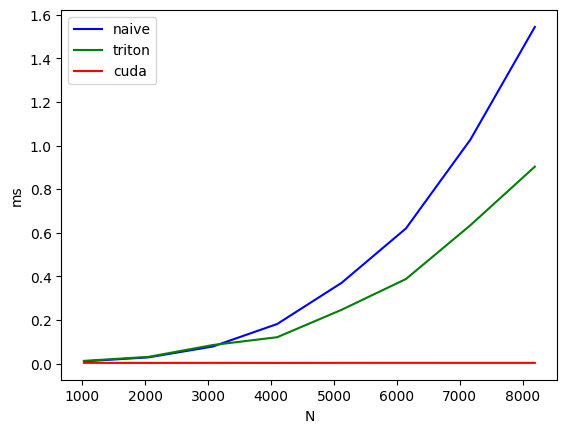

muon:
        N     naive    triton      cuda
0  1024.0  0.010073  0.012151  0.003139
1  2048.0  0.028228  0.030456  0.002796
2  3072.0  0.078057  0.084861  0.003088
3  4096.0  0.181412  0.120780  0.002789
4  5120.0  0.370362  0.246647  0.003091
5  6144.0  0.620314  0.388048  0.003050
6  7168.0  1.027804  0.634725  0.003075
7  8192.0  1.544641  0.903523  0.003065


In [19]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['naive', 'triton',"cuda"],  # possible values for `line_arg``
        line_names=[
            "naive",
            "triton",
            "cuda"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="muon",  # name for the plot. Used also as a file name for saving the plot.
        args={},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(N, provider):
    device = "cuda"
    dtype = torch.bfloat16
    x = torch.randn(N, N, device=device, dtype=dtype)
    out = torch.empty_like(x)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'naive':
        ms = triton.testing.do_bench(lambda: torch.matmul(x, x.t()))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: matmul(x, out))
    if provider == 'cuda':
        ms = triton.testing.do_bench(lambda: matmul_transpose(x))
    return ms
benchmark.run(show_plots=True, print_data=True)

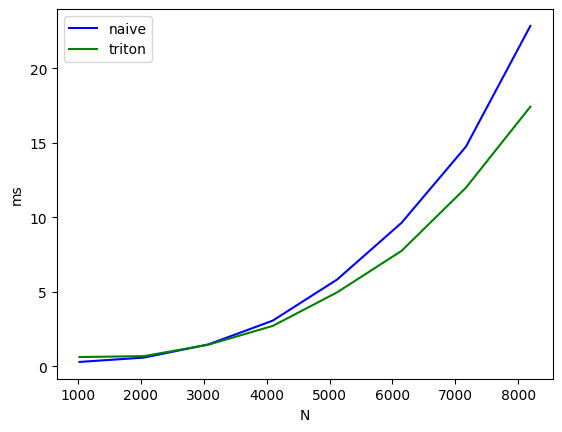

muon:
        N      naive     triton
0  1024.0   0.282652   0.609693
1  2048.0   0.572634   0.671413
2  3072.0   1.455426   1.437495
3  4096.0   3.053827   2.699235
4  5120.0   5.814272   4.953599
5  6144.0   9.623940   7.736847
6  7168.0  14.736821  11.981832
7  8192.0  22.842152  17.418835


In [36]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['naive', 'triton'],  # possible values for `line_arg``
        line_names=[
            "naive",
            "triton",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="muon",  # name for the plot. Used also as a file name for saving the plot.
        args={},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(N, provider):
    device = "cuda"
    dtype = torch.bfloat16
    x = torch.randn(N, N, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'naive':
        ms = triton.testing.do_bench(lambda: run_torch(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: run_triton(x))
    return ms
benchmark.run(show_plots=True, print_data=True)